# **Распознавание окурков сигарет**

Я использую Google Colab, а исходники храню на Google Drive, чтобы при исчезновении виртуальной машины всё сохранялось. Поэтому вначале надо всё настроить. Что хорошо, можно запускать и повторно - ничего не сломается и отработает быстро. 

Вам первый блок может и не понадобиться.

In [26]:
import os
from google.colab import drive

drive.mount('/content/gdrive')

work_root = "/content/gdrive/My Drive/cigarette_butt_segmentation"
%cd "$work_root"
data_root = '/content/data'
if not os.path.exists(data_root):
    !unzip data/cig_butts.zip -d $data_root
    !mv $data_root/cig_butts/* $data_root
    !rm -r $data_root/cig_butts 
out_dir = work_root + '/results'
weights_file_name_templ = out_dir + '/CigHeadWeights_Epoch%d.h5'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/cigarette_butt_segmentation


In [2]:
import cv2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from PIL import ImageFile
from glob import glob

from lib import *
from lib.net import *
from lib.dataset import *

import lib.detection.transforms as T
from lib.detection import train
from lib.detection.det_utils import *

%matplotlib inline

# Крайне полезно для отладки
%load_ext autoreload
%autoreload 2

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2
model = get_instance_segmentation_model(num_classes, True)
model.to(device)
epochNum = 0

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

In [20]:
# На данный момент здесь читается наилучшее состояние модели.
# В процессе экспериентов иногда хочется остановить тренировку ниже и сохранить текущее состояние.
# Это тоже можно сделать здесь, если заменить 0 на 1 в первом if
if 0:
    save_model_state(model.roi_heads.mask_predictor, weights_file_name_templ % epochNum)
    save_model_state(model, (weights_file_name_templ % epochNum) + '_full')
elif 1:
    epochNum = 34
    load_model_state(model.roi_heads.mask_predictor, weights_file_name_templ % epochNum)
    load_model_state(model, (weights_file_name_templ % epochNum) + '_full')  

State loaded from /content/gdrive/My Drive/cigarette_butt_segmentation/results/CigHeadWeights_Epoch34.h5 (<All keys matched successfully>)
State loaded from /content/gdrive/My Drive/cigarette_butt_segmentation/results/CigHeadWeights_Epoch34.h5_full (<All keys matched successfully>)


Моя augmentation путём копирования окурков в случайные места показала плохие результаты, поэтому сейчас она отключена. Можно включить, раскомментировав блок if train... в начале

In [5]:
def get_transform(train):
    transforms = []
    # if train:
    #     transforms.append(T.RandomMaskedObjectCopy(10))
    # Converts a PIL image into PyTorch Tensor. My RandomMaskedObjectCopy works on PIL images so it has to be before
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))        
    return T.Compose(transforms)
    
dataset = CigDataset(data_root + '/train', get_transform(train=True))
dataset_test = CigDataset(data_root + '/val', get_transform(train=False))

torch.manual_seed(1)

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=8, shuffle=True, num_workers=4,
    collate_fn=collate_fn)
data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

2000 images found
200 images found


Можно проверить, что получилось после аугментации:

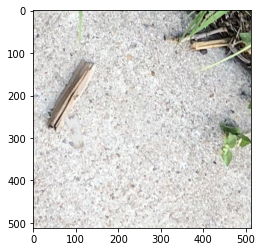

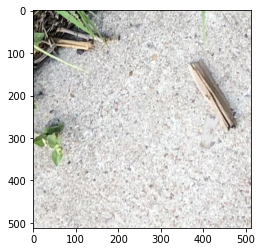

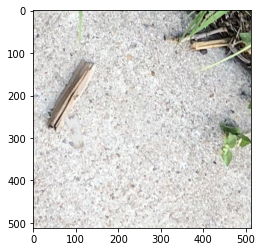

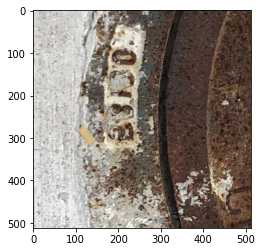

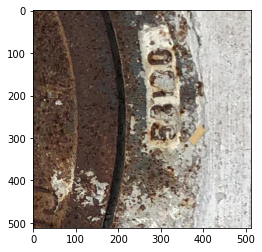

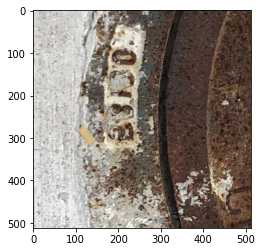

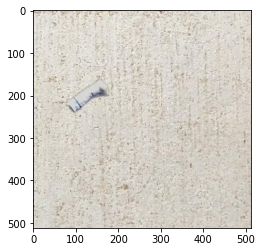

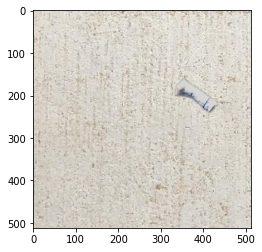

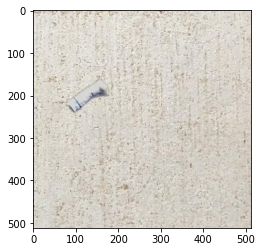

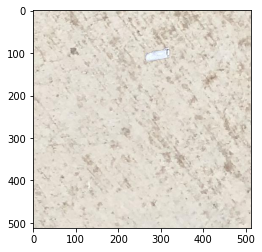

In [6]:
for i in range(10):
    img, target = dataset[i // 3 + 1]
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

In [7]:
num_epochs = 100

learnRate = 0.002
for epoch in range(num_epochs):
    # train.evaluate(model, data_loader_test, device=device, printFunc=printProgress)   
    for g in optimizer.param_groups:
        g['lr'] = learnRate
    train.train_one_epoch(model, optimizer, data_loader, device, epochNum, 
                          print_freq=10, printFunc=printProgress)
    
    epochNum += 1
    if epochNum % 5 == 0:
        save_model_state(model.roi_heads.mask_predictor, weights_file_name_templ % epochNum)
        save_model_state(model, (weights_file_name_templ % epochNum) + '_full') 
    train.evaluate(model, data_loader_test, device=device, printFunc=printProgress)    
    
    if epochNum % 15 == 0:
        learnRate /= 5    

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


Epoch: [34]  [  0/250]  eta: 0:10:51  lr: 0.002000  loss: 0.0826 (0.0826)  loss_classifier: 0.0050 (0.0050)  loss_box_reg: 0.0066 (0.0066)  loss_mask: 0.0709 (0.0709)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0001 (0.0001)  time: 2.6071  data: 0.8987  max mem: 5797
Epoch: [34]  [ 10/250]  eta: 0:04:32  lr: 0.002000  loss: 0.0767 (0.0764)  loss_classifier: 0.0053 (0.0056)  loss_box_reg: 0.0061 (0.0061)  loss_mask: 0.0646 (0.0645)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0001 (0.0001)  time: 1.1356  data: 0.1044  max mem: 6075
Epoch: [34]  [ 20/250]  eta: 0:04:04  lr: 0.002000  loss: 0.0740 (0.0756)  loss_classifier: 0.0051 (0.0053)  loss_box_reg: 0.0059 (0.0061)  loss_mask: 0.0631 (0.0640)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0001 (0.0001)  time: 0.9877  data: 0.0247  max mem: 6075
Epoch: [34]  [ 30/250]  eta: 0:03:48  lr: 0.002000  loss: 0.0740 (0.0754)  loss_classifier: 0.0053 (0.0055)  loss_box_reg: 0.0056 (0.0060)  loss_mask: 0.0621 (0.06

KeyboardInterrupt: ignored

# Анализ получившейся сети

Image 0 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.925, 0.947, 0.957, 0.966, 0.928, masks: torch.Size([1, 1, 512, 512]), 1
Image 1 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.927, 0.963, 0.981, 0.970, 0.901, masks: torch.Size([1, 1, 512, 512]), 1
Image 2 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.919, 0.965, 0.963, 0.945, 0.869, masks: torch.Size([1, 1, 512, 512]), 1
Image 3 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.452, 0.468, 0.480, 0.491, 0.472, masks: torch.Size([2, 1, 512, 512]), 2
Mask min 0.50, max 1.00, coords (246.0, 45.0), area 2408, target area 2243
Mask min 0.50, max 1.00, coords (131.0, 106.0), area 1479, target area 2243


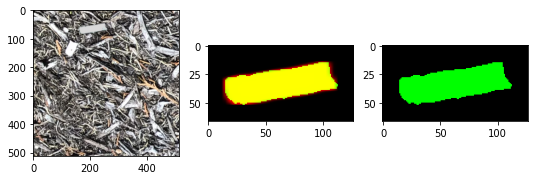

Image 4 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.926, 0.959, 0.969, 0.968, 0.907, masks: torch.Size([1, 1, 512, 512]), 1
Image 5 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.915, 0.957, 0.971, 0.958, 0.894, masks: torch.Size([1, 1, 512, 512]), 1
Image 6 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.928, 0.958, 0.977, 0.977, 0.928, masks: torch.Size([1, 1, 512, 512]), 1
Image 7 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.901, 0.928, 0.940, 0.938, 0.903, masks: torch.Size([1, 1, 512, 512]), 1
Mask min 0.50, max 1.00, coords (147.0, 220.0), area 708, target area 666


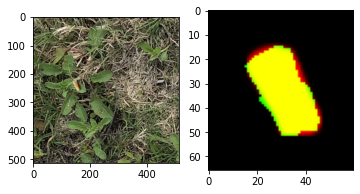

Image 8 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.913, 0.952, 0.972, 0.970, 0.904, masks: torch.Size([1, 1, 512, 512]), 1
Image 9 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.904, 0.939, 0.954, 0.948, 0.908, masks: torch.Size([1, 1, 512, 512]), 1
Image 10 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.931, 0.959, 0.975, 0.970, 0.914, masks: torch.Size([1, 1, 512, 512]), 1
Image 11 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.916, 0.959, 0.979, 0.970, 0.892, masks: torch.Size([1, 1, 512, 512]), 1
Image 12 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.909, 0.942, 0.966, 0.971, 0.946, masks: torch.Size([1, 1, 512, 512]), 1
Image 13 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.903, 0.955, 0.971, 0.953, 0.855, masks: torch.Size([1, 1, 512, 512]), 1
Image 14 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.914, 0.952, 0.968, 0.963, 0.909, masks: torch.Size([1, 1, 512, 512]), 1
Image 15 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.909, 0.950, 0.973, 0.969, 0.894, masks: torch.Size([1, 1, 512, 512

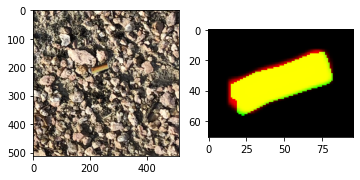

Image 17 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.945, 0.970, 0.978, 0.984, 0.940, masks: torch.Size([1, 1, 512, 512]), 1
Image 18 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.921, 0.942, 0.954, 0.963, 0.934, masks: torch.Size([1, 1, 512, 512]), 1
Image 19 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.912, 0.949, 0.968, 0.977, 0.947, masks: torch.Size([1, 1, 512, 512]), 1
Image 20 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.898, 0.941, 0.969, 0.978, 0.901, masks: torch.Size([1, 1, 512, 512]), 1
Image 21 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.896, 0.942, 0.964, 0.962, 0.883, masks: torch.Size([1, 1, 512, 512]), 1
Image 22 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.929, 0.954, 0.955, 0.938, 0.886, masks: torch.Size([1, 1, 512, 512]), 1
Image 23 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.845, 0.923, 0.951, 0.928, 0.747, masks: torch.Size([1, 1, 512, 512]), 1
Image 24 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.904, 0.942, 0.965, 0.967, 0.903, masks: torch.Size([1, 1, 512, 5

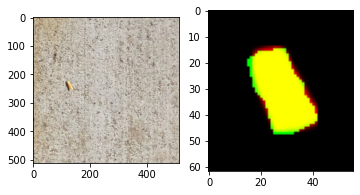

Image 28 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.911, 0.953, 0.973, 0.964, 0.896, masks: torch.Size([1, 1, 512, 512]), 1
Image 29 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.900, 0.943, 0.968, 0.960, 0.882, masks: torch.Size([1, 1, 512, 512]), 1
Image 30 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.897, 0.941, 0.963, 0.961, 0.898, masks: torch.Size([1, 1, 512, 512]), 1
Image 31 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.925, 0.961, 0.964, 0.950, 0.888, masks: torch.Size([1, 1, 512, 512]), 1
Image 32 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.947, 0.967, 0.972, 0.967, 0.936, masks: torch.Size([1, 1, 512, 512]), 1
Image 33 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.453, 0.475, 0.485, 0.481, 0.440, masks: torch.Size([2, 1, 512, 512]), 2
Mask min 0.50, max 1.00, coords (128.0, 347.0), area 3032, target area 2988
Mask min 0.50, max 1.00, coords (12.0, 175.0), area 520, target area 2988


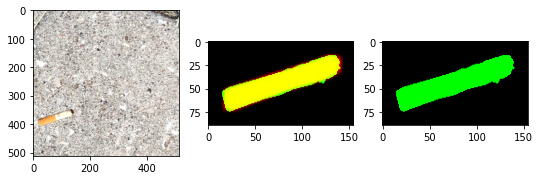

Image 34 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.903, 0.939, 0.951, 0.944, 0.863, masks: torch.Size([1, 1, 512, 512]), 1
Image 35 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.444, 0.462, 0.473, 0.476, 0.469, masks: torch.Size([2, 1, 512, 512]), 2
Mask min 0.50, max 1.00, coords (385.0, 342.0), area 1713, target area 1568
Mask min 0.50, max 1.00, coords (189.0, 383.0), area 874, target area 1568


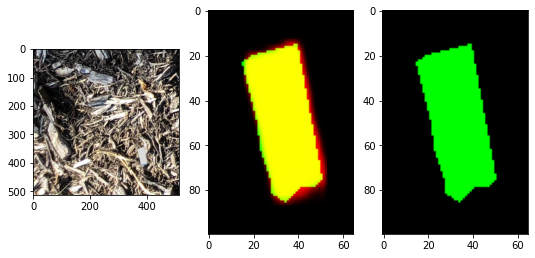

Image 36 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.921, 0.951, 0.965, 0.970, 0.931, masks: torch.Size([1, 1, 512, 512]), 1
Image 37 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.927, 0.966, 0.985, 0.963, 0.882, masks: torch.Size([1, 1, 512, 512]), 1
Image 38 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.935, 0.961, 0.965, 0.952, 0.878, masks: torch.Size([1, 1, 512, 512]), 1
Image 39 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.909, 0.950, 0.975, 0.964, 0.877, masks: torch.Size([1, 1, 512, 512]), 1
Image 40 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.912, 0.949, 0.968, 0.960, 0.877, masks: torch.Size([1, 1, 512, 512]), 1
Image 41 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.913, 0.953, 0.969, 0.963, 0.904, masks: torch.Size([1, 1, 512, 512]), 1
Image 42 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.915, 0.958, 0.975, 0.959, 0.871, masks: torch.Size([1, 1, 512, 512]), 1
Image 43 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.915, 0.950, 0.974, 0.969, 0.917, masks: torch.Size([1, 1, 512, 5

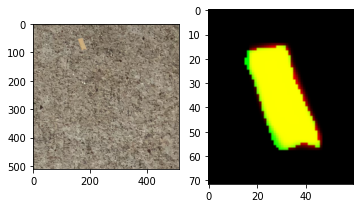

Image 50 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.940, 0.958, 0.962, 0.941, 0.876, masks: torch.Size([1, 1, 512, 512]), 1
Image 51 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.897, 0.946, 0.974, 0.968, 0.887, masks: torch.Size([1, 1, 512, 512]), 1
Image 52 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.913, 0.954, 0.973, 0.960, 0.877, masks: torch.Size([1, 1, 512, 512]), 1
Image 53 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.894, 0.942, 0.972, 0.970, 0.896, masks: torch.Size([1, 1, 512, 512]), 1
Image 54 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.906, 0.942, 0.952, 0.953, 0.902, masks: torch.Size([1, 1, 512, 512]), 1
Image 55 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.917, 0.957, 0.981, 0.975, 0.913, masks: torch.Size([1, 1, 512, 512]), 1
Image 56 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.901, 0.948, 0.965, 0.954, 0.877, masks: torch.Size([1, 1, 512, 512]), 1
Image 57 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.929, 0.963, 0.983, 0.973, 0.912, masks: torch.Size([1, 1, 512, 5

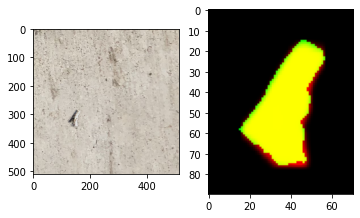

Image 65 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.868, 0.918, 0.954, 0.966, 0.904, masks: torch.Size([1, 1, 512, 512]), 1
Image 66 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.894, 0.939, 0.967, 0.967, 0.896, masks: torch.Size([1, 1, 512, 512]), 1
Image 67 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.927, 0.957, 0.969, 0.964, 0.903, masks: torch.Size([1, 1, 512, 512]), 1
Image 68 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.900, 0.944, 0.971, 0.976, 0.904, masks: torch.Size([1, 1, 512, 512]), 1
Image 69 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.869, 0.926, 0.967, 0.977, 0.872, masks: torch.Size([1, 1, 512, 512]), 1
Image 70 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.896, 0.944, 0.968, 0.965, 0.900, masks: torch.Size([1, 1, 512, 512]), 1
Image 71 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.892, 0.932, 0.957, 0.958, 0.899, masks: torch.Size([1, 1, 512, 512]), 1
Image 72 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.894, 0.939, 0.964, 0.970, 0.891, masks: torch.Size([1, 1, 512, 5

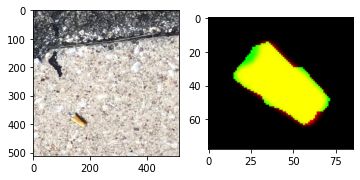

Image 77 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.922, 0.951, 0.963, 0.952, 0.881, masks: torch.Size([1, 1, 512, 512]), 1
Image 78 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.944, 0.960, 0.973, 0.971, 0.923, masks: torch.Size([1, 1, 512, 512]), 1
Image 79 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.918, 0.944, 0.953, 0.966, 0.934, masks: torch.Size([1, 1, 512, 512]), 1
Image 80 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.912, 0.951, 0.964, 0.965, 0.916, masks: torch.Size([1, 1, 512, 512]), 1
Image 81 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.945, 0.966, 0.972, 0.969, 0.940, masks: torch.Size([1, 1, 512, 512]), 1
Image 82 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.916, 0.957, 0.972, 0.966, 0.894, masks: torch.Size([1, 1, 512, 512]), 1
Image 83 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.911, 0.951, 0.973, 0.974, 0.914, masks: torch.Size([1, 1, 512, 512]), 1
Image 84 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.916, 0.960, 0.979, 0.965, 0.886, masks: torch.Size([1, 1, 512, 5

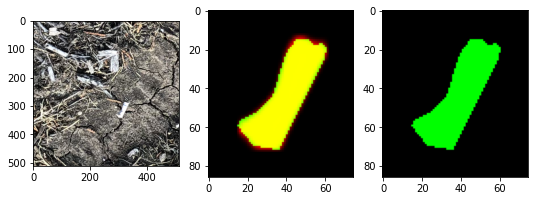

Image 116 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.910, 0.948, 0.971, 0.965, 0.910, masks: torch.Size([1, 1, 512, 512]), 1
Image 117 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.930, 0.964, 0.981, 0.973, 0.909, masks: torch.Size([1, 1, 512, 512]), 1
Image 118 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.915, 0.960, 0.973, 0.955, 0.874, masks: torch.Size([1, 1, 512, 512]), 1
Image 119 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.909, 0.945, 0.963, 0.953, 0.874, masks: torch.Size([1, 1, 512, 512]), 1
Image 120 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.904, 0.944, 0.966, 0.969, 0.913, masks: torch.Size([1, 1, 512, 512]), 1
Image 121 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.909, 0.951, 0.974, 0.976, 0.909, masks: torch.Size([1, 1, 512, 512]), 1
Image 122 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.914, 0.955, 0.967, 0.964, 0.888, masks: torch.Size([1, 1, 512, 512]), 1
Image 123 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.914, 0.945, 0.961, 0.965, 0.922, masks: torch.Size([1, 1

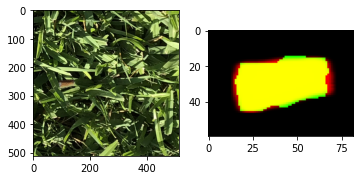

Image 132 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.923, 0.962, 0.980, 0.970, 0.904, masks: torch.Size([1, 1, 512, 512]), 1
Image 133 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.926, 0.956, 0.971, 0.976, 0.927, masks: torch.Size([1, 1, 512, 512]), 1
Image 134 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.000, 0.000, 0.000, 0.000, 0.000, masks: torch.Size([0, 1, 512, 512]), 0


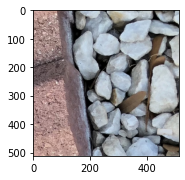

Image 135 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.924, 0.961, 0.967, 0.959, 0.893, masks: torch.Size([1, 1, 512, 512]), 1
Image 136 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.878, 0.936, 0.977, 0.955, 0.835, masks: torch.Size([1, 1, 512, 512]), 1
Image 137 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.903, 0.949, 0.977, 0.968, 0.883, masks: torch.Size([1, 1, 512, 512]), 1
Image 138 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.927, 0.948, 0.960, 0.961, 0.924, masks: torch.Size([1, 1, 512, 512]), 1
Image 139 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.921, 0.950, 0.964, 0.964, 0.911, masks: torch.Size([1, 1, 512, 512]), 1
Image 140 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.909, 0.948, 0.968, 0.964, 0.899, masks: torch.Size([1, 1, 512, 512]), 1
Image 141 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.925, 0.947, 0.957, 0.959, 0.915, masks: torch.Size([1, 1, 512, 512]), 1
Image 142 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.918, 0.950, 0.961, 0.968, 0.943, masks: torch.Size([1, 1

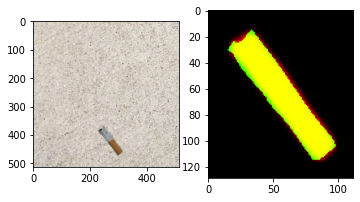

Image 153 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.914, 0.950, 0.971, 0.968, 0.912, masks: torch.Size([1, 1, 512, 512]), 1
Image 154 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.897, 0.942, 0.971, 0.973, 0.905, masks: torch.Size([1, 1, 512, 512]), 1
Image 155 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.919, 0.954, 0.968, 0.964, 0.910, masks: torch.Size([1, 1, 512, 512]), 1
Image 156 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.861, 0.913, 0.944, 0.951, 0.887, masks: torch.Size([1, 1, 512, 512]), 1
Mask min 0.50, max 1.00, coords (276.0, 30.0), area 1133, target area 1046


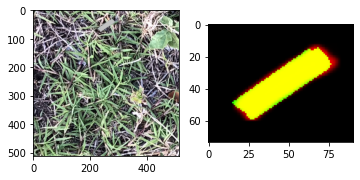

Image 157 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.915, 0.939, 0.957, 0.957, 0.914, masks: torch.Size([1, 1, 512, 512]), 1
Image 158 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.915, 0.958, 0.973, 0.960, 0.885, masks: torch.Size([1, 1, 512, 512]), 1
Image 159 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.892, 0.934, 0.967, 0.978, 0.917, masks: torch.Size([1, 1, 512, 512]), 1
Image 160 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.892, 0.948, 0.964, 0.944, 0.863, masks: torch.Size([1, 1, 512, 512]), 1
Image 161 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.915, 0.948, 0.960, 0.962, 0.901, masks: torch.Size([1, 1, 512, 512]), 1
Image 162 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.919, 0.953, 0.972, 0.965, 0.899, masks: torch.Size([1, 1, 512, 512]), 1
Image 163 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.896, 0.939, 0.949, 0.934, 0.864, masks: torch.Size([1, 1, 512, 512]), 1
Mask min 0.50, max 1.00, coords (43.0, 197.0), area 1478, target area 1466


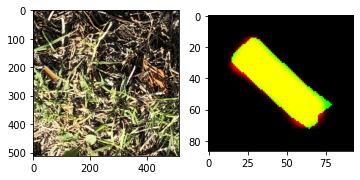

Image 164 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.896, 0.944, 0.974, 0.970, 0.888, masks: torch.Size([1, 1, 512, 512]), 1
Image 165 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.911, 0.944, 0.969, 0.982, 0.933, masks: torch.Size([1, 1, 512, 512]), 1
Image 166 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.909, 0.947, 0.960, 0.952, 0.890, masks: torch.Size([1, 1, 512, 512]), 1
Image 167 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.907, 0.934, 0.941, 0.942, 0.914, masks: torch.Size([1, 1, 512, 512]), 1
Mask min 0.51, max 1.00, coords (231.0, 128.0), area 970, target area 930


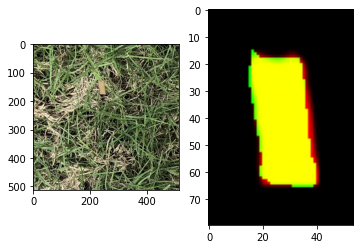

Image 168 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.904, 0.946, 0.973, 0.970, 0.892, masks: torch.Size([1, 1, 512, 512]), 1
Image 169 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.908, 0.955, 0.981, 0.964, 0.878, masks: torch.Size([1, 1, 512, 512]), 1
Image 170 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.929, 0.961, 0.972, 0.965, 0.903, masks: torch.Size([1, 1, 512, 512]), 1
Image 171 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.901, 0.944, 0.973, 0.971, 0.891, masks: torch.Size([1, 1, 512, 512]), 1
Image 172 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.883, 0.938, 0.965, 0.946, 0.835, masks: torch.Size([1, 1, 512, 512]), 1
Image 173 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.912, 0.953, 0.974, 0.965, 0.892, masks: torch.Size([1, 1, 512, 512]), 1
Image 174 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.927, 0.956, 0.967, 0.956, 0.884, masks: torch.Size([1, 1, 512, 512]), 1
Image 175 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.879, 0.925, 0.945, 0.954, 0.917, masks: torch.Size([1, 1

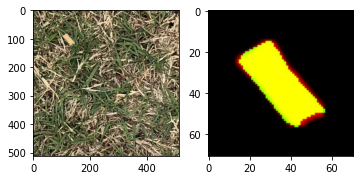

Image 176 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.907, 0.952, 0.977, 0.963, 0.884, masks: torch.Size([1, 1, 512, 512]), 1
Image 177 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.922, 0.959, 0.972, 0.971, 0.913, masks: torch.Size([1, 1, 512, 512]), 1
Image 178 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.892, 0.929, 0.954, 0.964, 0.909, masks: torch.Size([1, 1, 512, 512]), 1
Image 179 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.899, 0.947, 0.961, 0.957, 0.879, masks: torch.Size([1, 1, 512, 512]), 1
Image 180 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.924, 0.960, 0.977, 0.974, 0.922, masks: torch.Size([1, 1, 512, 512]), 1
Image 181 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.445, 0.475, 0.484, 0.466, 0.401, masks: torch.Size([2, 1, 512, 512]), 2
Mask min 0.50, max 1.00, coords (137.0, 223.0), area 1314, target area 1338
Mask min 0.50, max 1.00, coords (88.0, 249.0), area 2049, target area 1338


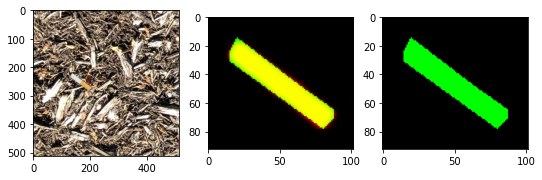

Image 182 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.915, 0.953, 0.977, 0.974, 0.923, masks: torch.Size([1, 1, 512, 512]), 1
Image 183 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.928, 0.959, 0.975, 0.967, 0.908, masks: torch.Size([1, 1, 512, 512]), 1
Image 184 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.910, 0.944, 0.969, 0.979, 0.942, masks: torch.Size([1, 1, 512, 512]), 1
Image 185 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.920, 0.951, 0.965, 0.967, 0.923, masks: torch.Size([1, 1, 512, 512]), 1
Image 186 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.925, 0.950, 0.963, 0.962, 0.905, masks: torch.Size([1, 1, 512, 512]), 1
Image 187 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.888, 0.937, 0.963, 0.966, 0.889, masks: torch.Size([1, 1, 512, 512]), 1
Image 188 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.916, 0.958, 0.981, 0.965, 0.888, masks: torch.Size([1, 1, 512, 512]), 1
Image 189 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.910, 0.946, 0.963, 0.957, 0.911, masks: torch.Size([1, 1

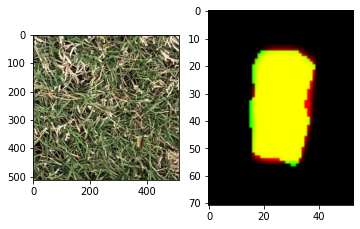

Image 193 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.891, 0.938, 0.963, 0.970, 0.896, masks: torch.Size([1, 1, 512, 512]), 1
Image 194 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.930, 0.958, 0.977, 0.970, 0.926, masks: torch.Size([1, 1, 512, 512]), 1
Image 195 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.912, 0.945, 0.963, 0.970, 0.931, masks: torch.Size([1, 1, 512, 512]), 1
Image 196 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.916, 0.955, 0.968, 0.960, 0.874, masks: torch.Size([1, 1, 512, 512]), 1
Image 197 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.907, 0.945, 0.964, 0.979, 0.947, masks: torch.Size([1, 1, 512, 512]), 1
Image 198 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.916, 0.957, 0.972, 0.966, 0.897, masks: torch.Size([1, 1, 512, 512]), 1
Image 199 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.897, 0.942, 0.971, 0.971, 0.893, masks: torch.Size([1, 1, 512, 512]), 1
Threshold 0.500000 dices: [0.         0.47302652 0.48032681 0.48378582 0.48538206 0.48685969
 0.93823827 0.9403

In [9]:
def show_pred_masks(dataset, img_idxs, plot_col_count,
                    log_thresholds, threshold_to_use_ind):
    """Runs model on the images, calculate dices on them on different thresholds
    and plot masks with dice < 0.95. Threshold means that all pixels with prediction <= threshold
    are considered not included into mask and all with > - included
    """

    model.eval()
    plot_row_count = 1
    dices = []
    with torch.no_grad():
        for img_idx2, img_idx in enumerate(img_idxs):
            img, target = dataset[img_idx]
            images = images_to_device(img, device)
            targets = targets_to_device(target, device)
            pred = model(images)
            masks = pred[0]['masks'].cpu()

            mask_count = masks.shape[0]
            cur_dices = []
            for threshold in log_thresholds:
                if mask_count != 0:
                    dice = get_dice(target['masks'][0].numpy().astype(bool),
                                    masks[0, 0].numpy() > threshold) / mask_count
                        # Некоторая вариация метрики - лишние предсказанные маски кратно понижают оценку
                else:
                    dice = 0
                cur_dices.append(dice)
            print('Image %d 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: %s, masks: %s, %d' % \
                (img_idx, ', '.join([('%.3f' % d) for d in cur_dices]), masks.shape, mask_count))
            dices.append(cur_dices[threshold_to_use_ind])
            if cur_dices[threshold_to_use_ind] > 0.95:
                continue

            plt.figure(figsize=(12, 8))        
            zero_mask = np.zeros(list(masks.shape[2:]))
            mask_sum = np.copy(zero_mask)        
            for mask_ind in range(min(plot_col_count - 1, mask_count)):
                mask = masks[mask_ind, 0].numpy()
                where = np.where(mask > log_thresholds[threshold_to_use_ind])
                target_where = np.where(target['masks'][0].numpy() > 0)
                print('Mask min %.2f, max %.2f, coords (%.1f, %.1f), area %d, target area %d' % \
                    (mask[where].min(), mask.max(), where[1][0], where[0][0], len(where[0]),
                    len(target_where[0])))
                mask_rgb = np.stack([mask, target['masks'][0], zero_mask], axis=2)
                mask_rgb = np.array(mask_rgb * 255, dtype=np.uint8)
                
                bbox = expand_bbox(target['boxes'][0].numpy().astype(int), 15, mask.shape[-1])
                ax = plt.subplot(plot_row_count, plot_col_count, mask_ind + 2)
                    # For plots matrix - also img_idx2 * plot_col_count + 
                im = ax.imshow(mask_rgb[bbox[1] : bbox[3], bbox[0] : bbox[2]]) # [100:400, 100:400]) 
            ax = plt.subplot(plot_row_count, plot_col_count, 1)
            im = ax.imshow(np.transpose(img, (1, 2, 0)))
            plt.show()
    return np.array(dices)

img_idxs = range(200)  
plot_col_count = 4
log_thresholds = [0.1, 0.3, 0.5, 0.7, 0.95]
threshold_to_use_ind = 2
dices = show_pred_masks(dataset_test, img_idxs, plot_col_count,
                        log_thresholds, threshold_to_use_ind)

sorted_dice_inds = np.argsort(dices)
print('Threshold %f dices: %s' % (log_thresholds[threshold_to_use_ind], dices[sorted_dice_inds]))
print('Dices mean: %.5f' % np.mean(dices))

# Сохранение результатов

In [21]:
# Снова прогоним модель на всех тестовых картинках (просто чтобы не связывать два куска кода)
threshold = 0.5
pred_masks_by_id = {}
model.eval()
with torch.no_grad():
    for img_idx2, (img, target) in enumerate(dataset_test):
        images = images_to_device(img, device)
        targets = targets_to_device(target, device)
        pred = model(images)
        masks = pred[0]['masks'].cpu().numpy()

        mask_count = masks.shape[0]
        if mask_count == 0:
            print('No mask for image %d' % img_idx2)
            mask2 = np.zeros(list(img.size())[-2:])
        else:
            mask = masks[0, 0]
            mask2 = (mask > threshold).astype(np.uint8)
            mask2[mask2 > 0] = 255
            img_id = int(targets[0]['image_id'])
        pred_masks_by_id[img_id] = mask2

In [22]:
# И сохраним их в одном формате
fieldNames = ['img_id', 'rle_mask']
table = []
for img_id, mask in pred_masks_by_id.items():
    table.append((img_id, encode_rle(mask)))
data_frame = pd.DataFrame(table, columns=fieldNames)
data_frame.to_csv('results/pred_val_template.csv', index=False)

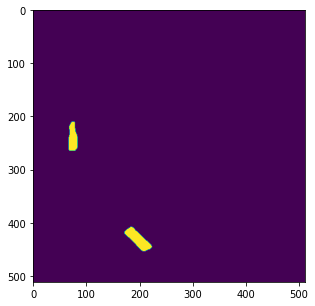

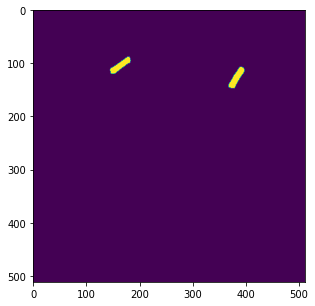

In [23]:
# Прогоним на папке real_test
paths_to_imgs = sorted(glob(f"{data_root}/real_test/*"))
img_ids = [int(path.split("/")[-1].split(".")[0]) for path in paths_to_imgs]
threshold = 0.5
pred_masks_by_id = {}
model.eval()
with torch.no_grad():
    transforms = get_transform(False)
    for img_idx2, paths_to_img in enumerate(paths_to_imgs):
        img = Image.open(paths_to_img).convert("RGB") 
        images = transforms(img, None)
        images = np.expand_dims(images[0], 0)
        images = torch.from_numpy(images).to(device)
        pred = model(images)
        masks = pred[0]['masks'].cpu().numpy()

        mask_count = masks.shape[0]
        if mask_count == 0:
            raise Exception('No mask for image %d' % img_idx2)
        
        mask = masks[0, 0]
        mask = (mask > threshold).astype(np.uint8)
        for mask_ind in range(1, mask_count):
            mask2 = masks[mask_ind, 0]
            mask[mask2 > threshold] = 2
        mask[mask > 0] = 255
        img_id = img_ids[img_idx2]
        pred_masks_by_id[img_id] = mask
        if img_idx2 < 2:
            plt.figure(figsize=(8, 5))        
            im = plt.imshow(mask)
            plt.show()

In [24]:
# И сохраним в другом формате
img_ids = [int(path.split("/")[-1].split(".")[0]) for path in paths_to_imgs]
print(img_ids)
masks = [pred_masks_by_id[img_id] for img_id in sorted(img_ids)]

path_to_save = "results/example"
generate_images_for_html(paths_to_imgs, masks, path_to_save=path_to_save)     
generate_html(path_to_save)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


"<!doctype html>\n<html>\n<head>\n<meta http-equiv='Content-Type' content='text/html; charset=utf-8'>\n<title>Визуализация результатов</title>\n</head>\n<body>\n<table cellspacing='0' cellpadding='5'>\n<tr>\n<td width='240' valign='top'>example/0000_img.jpg<br><img src='example/0000_img.jpg'alt='Something went wrong.'height='320' title='Original image:\nexample/0000_img.jpg'></td>\n<td width='240' valign='top'><img src='example/0000_pred_mask.png'alt='Something went wrong.'height='320' title='Predicted mask'></td>\n<td width='240' valign='top'><img src='example/0000_crop.png'alt='Something went wrong.'height='320' title='Cropped img according\npredicted mask'></td>\n<td width='100'></td>\n<td width='240' valign='top'>example/0001_img.jpg<br><img src='example/0001_img.jpg'alt='Something went wrong.'height='320' title='Original image:\nexample/0001_img.jpg'></td>\n<td width='240' valign='top'><img src='example/0001_pred_mask.png'alt='Something went wrong.'height='320' title='Predicted ma

В папке `results` создались файлы `pred_val_template.csv`, `example.html` и папка `examples` с используемыми картинками:

In [25]:
%ls -l results

total 1385465
-rw------- 1 root root   1053503 Oct  4 10:23 CigHeadWeights_Epoch34.h5
-rw------- 1 root root 176227836 Oct  4 10:23 CigHeadWeights_Epoch34.h5_full
-rw------- 1 root root   1053503 Oct  5 18:15 CigHeadWeights_Epoch35.h5
-rw------- 1 root root 176227496 Oct  5 18:16 CigHeadWeights_Epoch35.h5_full
-rw------- 1 root root   1053503 Oct  5 17:03 CigHeadWeights_Epoch40.h5
-rw------- 1 root root 176227496 Oct  5 17:03 CigHeadWeights_Epoch40.h5_full
-rw------- 1 root root   1053503 Oct  5 15:30 CigHeadWeights_Epoch41.h5
-rw------- 1 root root 176227498 Oct  5 15:30 CigHeadWeights_Epoch41.h5_full
-rw------- 1 root root   1053503 Oct  5 17:17 CigHeadWeights_Epoch43.h5
-rw------- 1 root root 176227496 Oct  5 17:17 CigHeadWeights_Epoch43.h5_full
-rw------- 1 root root   1053499 Oct  5 18:19 CigHeadWeights_Epoch5.h5
-rw------- 1 root root 176228210 Oct  5 18:19 CigHeadWeights_Epoch5.h5_full
-rw------- 1 root root   1053503 Oct  5 08:02 CigHeadWeights_Epoch67.h5
-rw------- 1 root root